# Session 2: Quick tour of Veneer

- Main features of Veneer (and veneer-py)
    - Starting a new notebook
    - Querying models
    - Running models and Retrieving results
    - Manipulating model setup and the ‘Allow Scripts’ option
    - PEST and Parallel processing
    - GUI and Command Line
    - Local and Remote connections
    - Getting help


## Start Source and Veneer

If you haven't already started Source, do so now, following the instructions in [0Setup_and_Hello_World.ipynb](0Setup_and_Hello_World.ipynb) to load and start Veneer using the `Tools|Web Server Monitoring` option.

## Starting a new Notebook

From an existing notebook, use the `File|New Notebook|Python 3` menu to start a new notebook using Python 3 syntax.

Alternatively, from the main Jupyter dashboard, use the New button.

It's probably worth using a Markdown cell at the top of the notebook to describe the purpose of the notebook (if only to remind yourself later...)

Then, in the first code block, you should `import` relevant Python packages and generally initialise your Python environment with anything needed for the notebook:

In [1]:
import veneer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### import

The Python `import` statement makes other packages available to your current session.

There are a few forms of `import`, two of which are illustrated here:

* `import veneer` makes the main veneer-py package available. You can access parts of the package using `veneer.<member>`
* `import pandas as pd` imports the pandas package, but aliases it as `pd` for convenience. For common packages (such as numpy adn pandas) there is often a well-used abbreviation, such as `np` and `pd`.
* `from os import mkdir, makedirs` imports one or more specific members of the os package and makes them available without any prefix
* `from os import *` imports all the members of the os package and makes them available without any prefix (eg `makedirs('test')`).

### %matplotlib

`%matplotlib` enables plotting by configuring a rendering engine for the matplotlib package. Anything starting with `%` is a special ('magic') command to Jupyter/IPython - it isn't standard Python.

The `%matplotlib` magic command accepts an optional parameter indicating which rendering backend to use for the current session. I've used `inline`, which renders charts directly within the notebook as HTML `<img>` tags. I find this best for creating self-sufficient notebooks that can be circulated and read without running. The downside is that the charts aren't interactive.

Other options worth noting:

* `%matplotlib` - (ie without specifying a rendering backend). This gives you the default for your current system. On my Windows machine, this uses the Qt4 windowing toolkit and charts appear in their own window, with basic zoom, pan, export and layout controls.
* `%matplotlib notebook` - Renders within the notebook with some basic interactive chart controls.

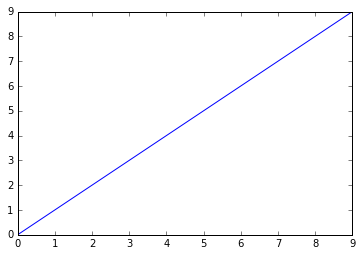

In [2]:
%matplotlib inline
plt.plot(range(10))

In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


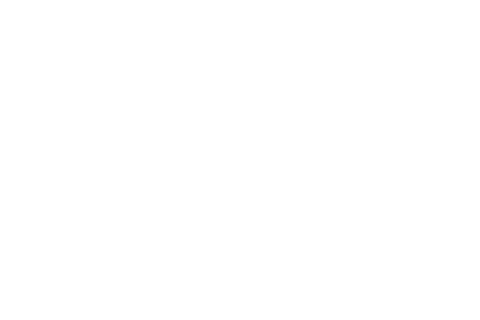

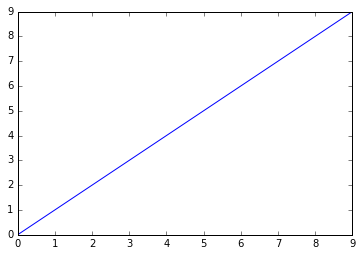

In [4]:
plt.plot(range(10))

In [5]:
%matplotlib inline

**Aside:** the `range` function is a generator. In this case, its generating a consecutive integers, starting from 0 and going up to, but not including, 10.

Try:

`print(range(10))`

and

`print(list(range(10))`

### Initialising a Veneer client

veneer-py provides functions for accessing a running copy of Source/Veneer. Most of these functions are provided through an instance of the `Veneer` client class, within the `veneer` package. You can have as many clients as you need - for example, to point to different copies of Source that are running concurrently.

By default, the client will attempt to connect to a copy of Source/Veneer running on the local machine and hosted on port 9876

In [6]:
v = veneer.Veneer()
# Equiavelent to
# v = veneer.Veneer(host='localhost',port=9876)

The rest of this tutorial uses `v` to refer to current Veneer client

## Querying models

veneer-py provides two groups of functions:

1. Functions for accessing the various URLs defined by Veneer (eg `v.network()` accesses the `/network` URL), and
2. Functions for accessing the catch-all, IronPython endpoint (eg `v.model.catchments.runoff.get_param_values('SMSC')` uses IronPython to query the SMSC parameter in the rainfall runoff models)

The functions in group 1 should work on all Source models, whereas the functions in group 2 tend to be more model specific.

This section deals with group 1 - functions related to specific URLs.

### Network queries

You can retrieve the current node link network (including catchment polygons if present) using `v.network()`. The result includes a list of `features`, which you can search and filter for particular nodes/links/catchments.

In [7]:
the_network = v.network()

*** /network ***


In [8]:
all_nodes = the_network['features'].find_by_feature_type('node')
len(all_nodes)

6

In [9]:
all_nodes._all_values('name')

['Ungauged Inflow', 'Storage', 'SP', 'MFR', 'Water User', 'End Of System']

You can also perform some basic topological queries on the network, such as finding all network outlets, or finding upstream/downstream links for a given node

In [10]:
outlets = the_network.outlet_nodes()
outlets

[{'geometry': {'type': 'Point', 'coordinates': [323, 718]}, 'properties': {'icon': '/resources/GaugeNodeModel', 'schematic_location': [323, 718], 'feature_type': 'node', 'name': 'End Of System'}, 'id': '/network/nodes/12', 'type': 'Feature'}]

In [11]:
the_network.upstream_links(outlets[0])

[{'geometry': {'type': 'LineString', 'coordinates': [[317, 560], [323, 718]]}, 'properties': {'from_node': '/network/nodes/6', 'to_node': '/network/nodes/12', 'feature_type': 'link', 'name': 'SR3'}, 'id': '/network/link/3', 'type': 'Feature'}]

If you have GeoPandas installed, you can convert network to a GeoDataFrame, which is useful for visualisation, reporting and advanced filtering.

In [12]:
network_df = the_network.as_dataframe()
network_df

,feature_type,from_node,geometry,icon,name,schematic_location,to_node,id
0,node,NaN,POINT (317 286),/resources/InjectedFlow,Ungauged Inflow,"[317, 286]",NaN,/network/nodes/1
1,node,NaN,POINT (317 393),/resources/StorageNodeModel,Storage,"[317, 393]",NaN,/network/nodes/3
2,node,NaN,POINT (317 560),/resources/ExtractionNodeModel,SP,"[317, 560]",NaN,/network/nodes/6
3,node,NaN,POINT (317 478),/resources/MinimumFlowConstraintModel,MFR,"[317, 478]",NaN,/network/nodes/10
4,node,NaN,POINT (200 619),/resources/WaterUserNodeModel,Water User,"[200, 619]",NaN,/network/nodes/11
5,node,NaN,POINT (323 718),/resources/GaugeNodeModel,End Of System,"[323, 718]",NaN,/network/nodes/12
6,link,/network/nodes/3,"LINESTRING (317 393, 317 478)",NaN,Default Link #4,NaN,/network/nodes/10,/network/link/0
7,link,/network/nodes/10,"LINESTRING (317 478, 317 560)",NaN,SR2,NaN,/network/nodes/6,/network/link/1
8,link,/network/nodes/6,"LINESTRING (317 560, 200 619)",NaN,Default Link #6,NaN,/network/nodes/11,/network/link/2
9,link,/network/nodes/6,"LINESTRING (317 560, 323 718)",NaN,SR3,NaN,/network/nodes/12,/network/link/3


With a GeoDataFrame, you can filter against any column

In [13]:
network_df[network_df.feature_type=='node']

,feature_type,from_node,geometry,icon,name,schematic_location,to_node,id
0,node,NaN,POINT (317 286),/resources/InjectedFlow,Ungauged Inflow,"[317, 286]",NaN,/network/nodes/1
1,node,NaN,POINT (317 393),/resources/StorageNodeModel,Storage,"[317, 393]",NaN,/network/nodes/3
2,node,NaN,POINT (317 560),/resources/ExtractionNodeModel,SP,"[317, 560]",NaN,/network/nodes/6
3,node,NaN,POINT (317 478),/resources/MinimumFlowConstraintModel,MFR,"[317, 478]",NaN,/network/nodes/10
4,node,NaN,POINT (200 619),/resources/WaterUserNodeModel,Water User,"[200, 619]",NaN,/network/nodes/11
5,node,NaN,POINT (323 718),/resources/GaugeNodeModel,End Of System,"[323, 718]",NaN,/network/nodes/12


In [14]:
network_df[network_df.icon=='/resources/StorageNodeModel']

,feature_type,from_node,geometry,icon,name,schematic_location,to_node,id
1,node,NaN,POINT (317 393),/resources/StorageNodeModel,Storage,"[317, 393]",NaN,/network/nodes/3


### Querying Functions and Variables

You can query all functions using `v.functions()`, and all variables with `v.variables()`.

In [15]:
model_functions = v.functions()
model_functions

*** /functions ***


[{'Expression': '/* Scaling factor 3.5 */\r\n3.5*$Runoff\r\n', 'Name': '$InflowCalc'}, {'Expression': 'lookup($MFR_Piecewise,$InflowCalc)\r\n', 'Name': '$FlowRequirement'}]

In [16]:
model_variables = v.variables()
model_variables

*** /variables ***


[{'FullName': '$Now.Day', 'VeneerDebugInfo': None, 'VeneerSupported': False, 'ID': 1, 'VariableType': 'NowVariable', 'Name': '$Day', 'PiecewiseFunction': None, 'TimeSeries': None}, {'FullName': '$Start.Day', 'VeneerDebugInfo': None, 'VeneerSupported': False, 'ID': 2, 'VariableType': 'FixedDateVariable', 'Name': '$Day', 'PiecewiseFunction': None, 'TimeSeries': None}, {'FullName': '$End.Day', 'VeneerDebugInfo': None, 'VeneerSupported': False, 'ID': 3, 'VariableType': 'FixedDateVariable', 'Name': '$Day', 'PiecewiseFunction': None, 'TimeSeries': None}, {'FullName': '$Now.Month', 'VeneerDebugInfo': None, 'VeneerSupported': False, 'ID': 4, 'VariableType': 'NowVariable', 'Name': '$Month', 'PiecewiseFunction': None, 'TimeSeries': None}, {'FullName': '$Start.Month', 'VeneerDebugInfo': None, 'VeneerSupported': False, 'ID': 5, 'VariableType': 'FixedDateVariable', 'Name': '$Month', 'PiecewiseFunction': None, 'TimeSeries': None}, {'FullName': '$End.Month', 'VeneerDebugInfo': None, 'VeneerSupported'

Both `v.functions()` and `v.variables()` return a searchable list:

In [17]:
model_variables.find_by_Name('$Runoff')

[{'FullName': '$Runoff', 'VeneerDebugInfo': 'DisplayName=$Runoff;ResultUnit=no unit selected (None);', 'VeneerSupported': True, 'ID': 20, 'VariableType': 'TimeSeriesVariable', 'Name': '$Runoff', 'PiecewiseFunction': None, 'TimeSeries': '/variables/Runoff/TimeSeries'}]

**Note:** When you get a searchable list, you can also convert it to a Pandas Data Frame if that is more convenient

In [18]:
model_variables.as_dataframe()

,FullName,ID,Name,PiecewiseFunction,TimeSeries,VariableType,VeneerDebugInfo,VeneerSupported
0,$Now.Day,1,$Day,None,None,NowVariable,None,False
1,$Start.Day,2,$Day,None,None,FixedDateVariable,None,False
2,$End.Day,3,$Day,None,None,FixedDateVariable,None,False
3,$Now.Month,4,$Month,None,None,NowVariable,None,False
4,$Start.Month,5,$Month,None,None,FixedDateVariable,None,False
5,$End.Month,6,$Month,None,None,FixedDateVariable,None,False
6,$Now.Year,7,$Year,None,None,NowVariable,None,False
7,$Start.Year,8,$Year,None,None,FixedDateVariable,None,False
8,$End.Year,9,$Year,None,None,FixedDateVariable,None,False
9,$Now.Hour,10,$Hour,None,None,NowVariable,None,False


`v.variables()` only returns summary information about the variable. If you want to get at the actual time series (or the piecewise linear function or similar), use `v.variable_time_series(name)` (or `v.variable_piecewise(name)`):

*** /variables/Runoff/TimeSeries ***


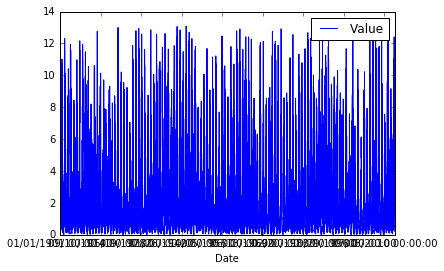

In [19]:
runoff_ts = v.variable_time_series('$Runoff')
runoff_ts.plot()

In [20]:
mfr_piecewise = v.variable_piecewise('MFR_Piecewise')
mfr_piecewise

*** /variables/MFR_Piecewise/Piecewise ***


,Lookup,Result
0,0,0.0
1,100,1.0
2,101,1.1
3,1000,100.0
4,10000,2000.0


**Note:** At this stage, only Time Series and Piecewise Linear variables are supported through this mechanism

### Data Sources

You can get a list of all Data Sources in the model with `v.data_sources()`

In [21]:
data_sources = v.data_sources()
data_sources

*** /dataSources ***


[{'FullName': '/ForcingData_csv', 'id': '/dataSources/ForcingData_csv', 'Path': '/', 'Items': [{'Details': [{'Name': 'Inflow', 'TimeSeries': {'Max': 13.09, 'Mean': 1.518634390521643, 'Min': 0, 'Units': 'mm/d', 'NoDataValue': -9999, 'EndDate': '12/31/2013 00:00:00', 'Sum': 62678.59719999978, 'StartDate': '01/01/1901 00:00:00', 'Name': 'Inflow', 'TimeStep': 'Daily'}}, {'Name': 'Rainfall', 'TimeSeries': {'Max': 210.9999, 'Mean': 3.9211440845104604, 'Min': 0, 'Units': 'mm/d', 'NoDataValue': -9999, 'EndDate': '12/31/2013 00:00:00', 'Sum': 161837.37980000023, 'StartDate': '01/01/1901 00:00:00', 'Name': 'Rainfall', 'TimeStep': 'Daily'}}, {'Name': 'PET', 'TimeSeries': {'Max': 8.502, 'Mean': 4.522002851743327, 'Min': 2.0902, 'Units': 'mm/d', 'NoDataValue': -9999, 'EndDate': '12/31/2013 00:00:00', 'Sum': 186636.62370000235, 'StartDate': '01/01/1901 00:00:00', 'Name': 'PET', 'TimeStep': 'Daily'}}], 'InputSets': ['Default Input Set'], 'Name': 'Default Input Set'}], 'Name': 'ForcingData_csv'}]

Using `.as_dataframe()` can help to interpret the information:

In [22]:
data_sources.as_dataframe()

,FullName,Items,Name,Path,id
0,/ForcingData_csv,"[{'Details': [{'Name': 'Inflow', 'TimeSeries':...",ForcingData_csv,/,/dataSources/ForcingData_csv


This highlights that the `Items` column has nested information:

In [23]:
data_sources[0]['Items']

[{'Details': [{'Name': 'Inflow',
    'TimeSeries': {'EndDate': '12/31/2013 00:00:00',
     'Max': 13.09,
     'Mean': 1.518634390521643,
     'Min': 0,
     'Name': 'Inflow',
     'NoDataValue': -9999,
     'StartDate': '01/01/1901 00:00:00',
     'Sum': 62678.59719999978,
     'TimeStep': 'Daily',
     'Units': 'mm/d'}},
   {'Name': 'Rainfall',
    'TimeSeries': {'EndDate': '12/31/2013 00:00:00',
     'Max': 210.9999,
     'Mean': 3.9211440845104604,
     'Min': 0,
     'Name': 'Rainfall',
     'NoDataValue': -9999,
     'StartDate': '01/01/1901 00:00:00',
     'Sum': 161837.37980000023,
     'TimeStep': 'Daily',
     'Units': 'mm/d'}},
   {'Name': 'PET',
    'TimeSeries': {'EndDate': '12/31/2013 00:00:00',
     'Max': 8.502,
     'Mean': 4.522002851743327,
     'Min': 2.0902,
     'Name': 'PET',
     'NoDataValue': -9999,
     'StartDate': '01/01/1901 00:00:00',
     'Sum': 186636.62370000235,
     'TimeStep': 'Daily',
     'Units': 'mm/d'}}],
  'InputSets': ['Default Input Set'],
  

So, `v.data_sources()` returns information about all data sources. Specifically, it returns the list of data sources, and, for each one, information about the different time series. However, `v.data_sources` _does not_ return the entire time series. (This is mainly for speed - on big models, this can be HUGE)

To get to the time series, either use `v.data_source(name)` to retrieve a single data source (and all the time series within it) OR `v.data_source_item(source,name)` to retrieve a particular time series.

**Note:** With `v.data_source_item` you can retrieve the time series for an item that is associated with a particular input set.

In [24]:
forcing = v.data_source('ForcingData_csv')
forcing

*** /dataSources/ForcingData_csv ***


{'FullName': '/ForcingData_csv',
 'Items': [{'Details':             Inflow  Rainfall     PET
 Date                                
 1901-01-01  0.1469    0.0000  3.2992
 1901-01-02  0.1381    3.3983  3.2992
 1901-01-03  0.5186    6.8529  3.2992
 1901-01-04  0.8163    1.0206  3.2992
 1901-01-05  0.7895    4.2553  3.2992
 1901-01-06  3.2796   34.5720  3.2992
 1901-01-07  2.3858    0.0000  3.2992
 1901-01-08  1.5464    0.0000  3.2992
 1901-01-09  1.0746    0.0000  3.2992
 1901-01-10  0.8072    0.0000  3.2992
 1901-01-11  0.6536    0.0000  3.2992
 1901-01-12  0.5633    0.0000  3.2992
 1901-01-13  0.5083    0.0000  3.2992
 1901-01-14  0.4730    0.0000  3.2992
 1901-01-15  0.4489    0.0000  3.2992
 1901-01-16  0.4310    0.1968  3.2992
 1901-01-17  0.4167    0.0038  3.2992
 1901-01-18  2.2677   23.7419  3.2992
 1901-01-19  1.6556    0.6581  3.2992
 1901-01-20  1.1583    0.0000  3.2992
 1901-01-21  0.8762    0.0000  3.2992
 1901-01-22  0.7139    0.0000  3.2992
 1901-01-23  0.6182    0.0000  3.

You can see that the time series are included, but they are still nested within the returned data. Essentially, Veneer has returned the data for each input set, with each being a separate Pandas DataFrame.

You can get to an individual DataFrame back with `find_one_by_Name`

In [25]:
forcing_as_df = forcing['Items'].find_one_by_Name('Default Input Set')['Details']
forcing_as_df[0:30] # Look at the first 30 time steps

,Inflow,Rainfall,PET
Date,,,
1901-01-01,0.1469,0.0000,3.2992
1901-01-02,0.1381,3.3983,3.2992
1901-01-03,0.5186,6.8529,3.2992
1901-01-04,0.8163,1.0206,3.2992
1901-01-05,0.7895,4.2553,3.2992
1901-01-06,3.2796,34.5720,3.2992
1901-01-07,2.3858,0.0000,3.2992
1901-01-08,1.5464,0.0000,3.2992
1901-01-09,1.0746,0.0000,3.2992


You can jump to a particular data source item (typically a column from an original file) with `v.data_source_item(source,name)`

In [26]:
rainfall = v.data_source_item('ForcingData_csv','Rainfall')
rainfall[0:30]

*** /dataSources/ForcingData_csv/__all__/Rainfall ***


,Default Input Set/Rainfall
Date,
01/01/1901 00:00:00,0.0000
01/02/1901 00:00:00,3.3983
01/03/1901 00:00:00,6.8529
01/04/1901 00:00:00,1.0206
01/05/1901 00:00:00,4.2553
01/06/1901 00:00:00,34.5720
01/07/1901 00:00:00,0.0000
01/08/1901 00:00:00,0.0000
01/09/1901 00:00:00,0.0000


### Input Sets

Veneer provides access to the scenario input sets - primarily the commands for changing individual model parameters - through `v.input_sets()

In [27]:
input_sets = v.input_sets()
input_sets

*** /inputSets ***


[{'URL': '/inputSets/Default Input Set', 'Name': 'Default Input Set', 'Configuration': ['Nodes.Ungauged Inflow.Elevation = 50 m', 'Nodes.Storage.Elevation = 15 m', 'Nodes.MFR.Elevation = 5 m']}]

Within a given input set, the individual commands are available in the `Configuration` property

In [28]:
input_sets.find_one_by_Name('Default Input Set')['Configuration']

['Nodes.Ungauged Inflow.Elevation = 50 m',
 'Nodes.Storage.Elevation = 15 m',
 'Nodes.MFR.Elevation = 5 m']

Input sets are a lot more interesting when you are changing them and applying them from Python...

## Running Models

You can run the current scenario, with its current settings (start/end date, input set, run configuration, etc) using `v.run_model()`

In [29]:
response,run_url = v.run_model()
response,run_url

(302, 'runs/1')

After a successful run, veneer-py returns the URL of the new run - this can be used to retrieve an index of all the available results and, from there, the actual time series results

In [30]:
run_url

'runs/1'

In [31]:
index = v.retrieve_run(run_url)
index

*** /runs/1 ***


{'DateRun': '10/18/2016 17:24:04',
 'Name': 'Scenario 1 (1)',
 'Number': 1,
 'Results': [{'RunNumber': 1, 'TimeSeriesName': 'Straight-Through Routing: Default Link #4: Upstream Flow', 'NetworkElement': 'Default Link #4', 'RecordingElement': 'Upstream Flow', 'TimeSeriesUrl': '/runs/1/location/Default Link 4/element/Upstream Flow/variable/Flow', 'RecordingVariable': 'Flow'}, {'RunNumber': 1, 'TimeSeriesName': 'Straight-Through Routing: Default Link #4: Catchment Inflow', 'NetworkElement': 'Default Link #4', 'RecordingElement': 'Catchment Inflow', 'TimeSeriesUrl': '/runs/1/location/Default Link 4/element/Catchment Inflow/variable/Flow', 'RecordingVariable': 'Flow'}, {'RunNumber': 1, 'TimeSeriesName': 'Straight-Through Routing: Default Link #4: Downstream Flow', 'NetworkElement': 'Default Link #4', 'RecordingElement': 'Downstream Flow', 'TimeSeriesUrl': '/runs/1/location/Default Link 4/element/Downstream Flow/variable/Flow', 'RecordingVariable': 'Flow'}, {'RunNumber': 1, 'TimeSeriesName': 

THis index lists all of the time series (under `['Results']`) and can be used to retrieve individual time series, or collections of time series

In [32]:
index['Results'].as_dataframe()

,NetworkElement,RecordingElement,RecordingVariable,RunNumber,TimeSeriesName,TimeSeriesUrl
0,Default Link #4,Upstream Flow,Flow,1,Straight-Through Routing: Default Link #4: Ups...,/runs/1/location/Default Link 4/element/Upstre...
1,Default Link #4,Catchment Inflow,Flow,1,Straight-Through Routing: Default Link #4: Cat...,/runs/1/location/Default Link 4/element/Catchm...
2,Default Link #4,Downstream Flow,Flow,1,Straight-Through Routing: Default Link #4: Dow...,/runs/1/location/Default Link 4/element/Downst...
3,Default Link #4,Storage Volume,Storage Volume,1,Straight-Through Routing: Default Link #4: Sto...,/runs/1/location/Default Link 4/element/Storag...
4,Default Link #4,Lateral Flow,Flow,1,Straight-Through Routing: Default Link #4: Lat...,/runs/1/location/Default Link 4/element/Latera...
5,Default Link #4,Upstream Flow Volume,Upstream Flow Volume,1,Straight-Through Routing: Default Link #4: Ups...,/runs/1/location/Default Link 4/element/Upstre...
6,Default Link #4,Downstream Flow Volume,Downstream Flow Volume,1,Straight-Through Routing: Default Link #4: Dow...,/runs/1/location/Default Link 4/element/Downst...
7,Default Link #4,Mass Balance,Mass Balance,1,Default Link #4: Mass Balance,/runs/1/location/Default Link 4/element/Mass B...
8,SR2,Upstream Flow,Flow,1,Storage Routing: SR2: Upstream Flow,/runs/1/location/SR2/element/Upstream Flow/var...
9,SR2,Catchment Inflow,Flow,1,Storage Routing: SR2: Catchment Inflow,/runs/1/location/SR2/element/Catchment Inflow/...


The easiest way to retrieve time series results is with `v.retrieve_multiple_time_series`, which takes a set of run results, some search criteria by which it identifies wanted time series. There are also options for retrieve aggregated data and the ability to rename time series as they are retrieved.

The help text for `retrieve_multiple_time_series` describes the options

In [33]:
help(v.retrieve_multiple_time_series)

Help on method retrieve_multiple_time_series in module veneer.general:

retrieve_multiple_time_series(run='latest', run_data=None, criteria={}, timestep='daily', name_fn=<function name_element_variable at 0x0000000005353378>) method of veneer.general.Veneer instance
    Retrieve multiple time series from a run according to some criteria.
    
    Return all time series in a single Pandas DataFrame with date time index.
    
    you can an index of run results via run_data. If you don't the method will first retrieve an
    index based on the value of the run parameter (default='latest')
    
    criteria should be regexps for the fields in a Veneer time series record:
      * NetworkElement
      * RecordingElement
      * RecordingVariable
      * TimeSeriesName
      * TimeSeriesUrl
    
    These criteria are used to identify which time series to retrieve.
    
    timestep should be one of 'daily' (default), 'monthly', 'annual'
    
    All retrieved time series are returned in a s

The following examples retrieve data from the latest run, using the `index` index we saved, earlier:

In [34]:
# Retrieve Downstream Flow Volume, anywhere it is recorded.
# Name the columns for the network location
ds_flow = v.retrieve_multiple_time_series(run_data=index,criteria={'RecordingVariable':'Downstream Flow Volume'},
                                          name_fn=veneer.name_for_location)
ds_flow[0:10]

*** /runs/1/location/Default Link 4/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/SR2/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/SR3/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/Default Link 5/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/Ungauged Inflow/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/Storage/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/SP/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/MFR/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/Water User/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/End Of System/element/Downstream Flow Volume/variable/Downstream Flow Volume ***


,Default Link #4,Default Link #5,End Of System,MFR,SP,SR2,SR3,Storage,Ungauged Inflow,Water User
1901-01-01,0.000000,514.15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,514.15,0
1901-01-02,0.000000,483.35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,483.35,0
1901-01-03,6349.027111,1815.10,6349.027111,6349.027111,6349.027111,6349.027111,6349.027111,6349.027111,1815.10,0
1901-01-04,0.000000,2857.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2857.05,0
1901-01-05,0.000000,2763.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2763.25,0
1901-01-06,316601.314118,11478.60,316601.314118,316601.314118,316601.314118,316601.314118,316601.314118,316601.314118,11478.60,0
1901-01-07,0.000000,8350.30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8350.30,0
1901-01-08,0.000000,5412.40,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5412.40,0
1901-01-09,0.000000,3761.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3761.10,0
1901-01-10,0.000000,2825.20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2825.20,0


In [35]:
# Retrieve everything available from the Water User node
# Name the columns for the variable
water_user = v.retrieve_multiple_time_series(run_data=index,criteria={'NetworkElement':'Water User'},
                                          name_fn=veneer.name_for_variable)
water_user[0:10]

*** /runs/1/location/Water User/element/Upstream Flow/variable/Flow ***
*** /runs/1/location/Water User/element/Downstream Flow/variable/Flow ***
*** /runs/1/location/Water User/element/Storage Volume/variable/Storage Volume ***
*** /runs/1/location/Water User/element/Upstream Flow Volume/variable/Upstream Flow Volume ***
*** /runs/1/location/Water User/element/Downstream Flow Volume/variable/Downstream Flow Volume ***
*** /runs/1/location/Water User/element/Demand & Storage Interface/variable/Demand & Storage Interface@Demand Model@Regulated Requirements ***
*** /runs/1/location/Water User/element/Demand & Storage Interface/variable/Demand & Storage Interface@Demand Model@Regulated Water Supplied ***
*** /runs/1/location/Water User/element/Demand Model/variable/Demand Model@Crops@Crop Type 0@Area ***
*** /runs/1/location/Water User/element/Demand Model/variable/Demand Model@Crops@Crop Type 0@Crop Production ***
*** /runs/1/location/Water User/element/Demand Model/variable/Demand Model

,Demand & Storage Interface@Demand Model@Regulated Requirements,Demand & Storage Interface@Demand Model@Regulated Water Supplied,Demand Model@Crops@Crop Type #0@Area,Demand Model@Crops@Crop Type #0@Crop Production,Demand Model@Crops@Crop Type #0@Crop Yield,Demand Model@Crops@Crop Type #0@Evapo-Transpiration,Demand Model@Crops@Crop Type #0@Requirement,Demand Model@Crops@Crop Type #0@Soil Depletion,Demand Model@Crops@Crop Type #0@Water Supplied,Downstream Flow Volume,Flow,Mass Balance,Storage Volume,Upstream Flow Volume
1901-01-01,9897.6,0,10000000,0,0,0.00099,9897.6,9.897600e-04,0,0,0,0,0,0
1901-01-02,0.0,0,10000000,0,0,0.00099,0.0,0.000000e+00,0,0,0,0,0,0
1901-01-03,0.0,0,10000000,0,0,0.00099,0.0,-2.168404e-19,0,0,0,0,0,0
1901-01-04,6290.0,0,10000000,0,0,0.00099,6290.0,6.290000e-04,0,0,0,0,0,0
1901-01-05,0.0,0,10000000,0,0,0.00099,0.0,-2.168404e-19,0,0,0,0,0,0
1901-01-06,0.0,0,10000000,0,0,0.00099,0.0,4.336809e-19,0,0,0,0,0,0
1901-01-07,9897.6,0,10000000,0,0,0.00099,9897.6,9.897600e-04,0,0,0,0,0,0
1901-01-08,19795.2,0,10000000,0,0,0.00099,19795.2,1.979520e-03,0,0,0,0,0,0
1901-01-09,29692.8,0,10000000,0,0,0.00099,29692.8,2.969280e-03,0,0,0,0,0,0
1901-01-10,39590.4,0,10000000,0,0,0.00099,39590.4,3.959040e-03,0,0,0,0,0,0


#### Other run related actions

There are numerous functions and options that are closely related to running simulations:

* You can call `v.run_model()` with alternate `start` and `end` dates, along with other options related to the simulation, such as specifying an input set
* You can call `v.apply_input_set()` to run the commands in a particular input set. This doesn't trigger a run, so its useful in situations where you want to run multiple input sets before a single simulation
* `v.configure_recording()` can switch time series recorders on and off
* You can drop a run from memory (`v.drop_run`) or drop _all_ runs (`v.drop_all_runs()`)

These actions will all be covered in subsequent tutorials. For now, a simple example of enabling recording of `Storage Surface Area` and rerunning:

In [36]:
v.drop_all_runs()
v.configure_recording(enable=[{'RecordingVariable':'Storage Surface Area'}])
v.run_model()

*** /runs ***
*** /runs ***


(302, 'runs/1')

*** /runs/latest ***
*** /runs/1/location/Storage/element/Storage Surface Area/variable/Storage Surface Area ***


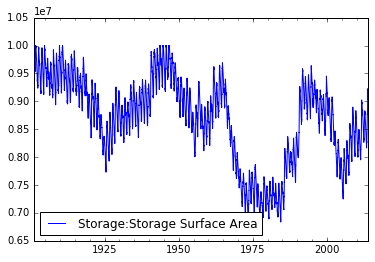

In [37]:
surface_area = v.retrieve_multiple_time_series(criteria={'RecordingVariable':'Storage Surface Area'})
surface_area.plot()

**Note:** We again drop all runs before moving on...

In [38]:
v.drop_all_runs()

*** /runs ***
*** /runs ***


## Manipulating model setup and the ‘Allow Scripts’ option

There are various ways to use veneer-py to change the configuration of the currently loaded model in Source

1. Methods to update input sets with new parameters (`v.update_input_set`)
2. Applying a particular input set (`v.apply_input_set`)
3. Use functionality under `v.model.` to directly change model parameters and structure

It is also possible to modify files on disk where Source is configured to 'Reload-On-Run', such as changing time series files or input set command files. This option isn't specific to Veneer/veneer-py and isn't covered in these tutorials.


We can update the input set commands for the default input set.

(Making a single change like this can be a bit fiddly!)

In [39]:
default_input_set = v.input_sets()[0]
default_input_set

*** /inputSets ***


{'Configuration': ['Nodes.Ungauged Inflow.Elevation = 50 m',
  'Nodes.Storage.Elevation = 15 m',
  'Nodes.MFR.Elevation = 5 m'],
 'Name': 'Default Input Set',
 'URL': '/inputSets/Default Input Set'}

In [40]:
command_of_interest = default_input_set['Configuration'][0]
command_of_interest

'Nodes.Ungauged Inflow.Elevation = 50 m'

In [41]:
default_input_set['Configuration'][0] = command_of_interest.replace('25 m','50 m')

In [42]:
default_input_set

{'Configuration': ['Nodes.Ungauged Inflow.Elevation = 50 m',
  'Nodes.Storage.Elevation = 15 m',
  'Nodes.MFR.Elevation = 5 m'],
 'Name': 'Default Input Set',
 'URL': '/inputSets/Default Input Set'}

In [43]:
v.update_input_set('Default Input Set',default_input_set)

(200, None)

**At this point, you can check in the Source user interface (Edit|Scenario Input Sets) to see that the input set has been updated. Alternatively, you can query the input set again**

In [44]:
v.input_sets()

*** /inputSets ***


[{'URL': '/inputSets/Default Input Set', 'Name': 'Default Input Set', 'Configuration': ['Nodes.Ungauged Inflow.Elevation = 50 m', 'Nodes.Storage.Elevation = 15 m', 'Nodes.MFR.Elevation = 5 m']}]

The Default Input Set would be applied when we next run, but if we want those parameters set on the model immediately, we can do so, with `v.apply_input_set('Default Input Set')`

In [45]:
v.apply_input_set('Default Input Set')

(200, None)

### `v.model` and the Allow Scripts option

The `v.model` namespace contains a lot of functionality for modifying the structure of the Source model. This part of veneer-py works by generating IronPython scripts, which run directly within Source and manipulate the .NET objects that Source is built upon.

This capability (to accept IronPython scripts) is disabled, by default, in Veneer. To enable it, click the 'Allow Scripts' checkbox in the Web Server Monitoring window. **If you don't enable the 'Allow Scripts' option, then the following instructions will give an error.**

As an example of what can be done, the following command queries the routing model used for each link

In [46]:
v.model.link.routing.get_models()

['RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StraightThroughRouting',
 'RiverSystem.Flow.StorageRouting',
 'RiverSystem.Flow.StraightThroughRouting']

This shows that, for the example model, there are three Straight Through Routing links and two Storage Routing links.

`get_models()` has returned a list - and this is common within the `v.model` namespace. It's also common for functions to accept a list when changing the Source model (eg by changing assigned models, or changing parameters).

The list isn't directly useful though, because it doesn't tell you which link is which. That can be checked by asking for the results coded by name

In [48]:
v.model.link.routing.get_models(by_name=True)

{'Default Link #4': 'RiverSystem.Flow.StraightThroughRouting',
 'Default Link #5': 'RiverSystem.Flow.StraightThroughRouting',
 'Default Link #6': 'RiverSystem.Flow.StraightThroughRouting',
 'SR2': 'RiverSystem.Flow.StorageRouting',
 'SR3': 'RiverSystem.Flow.StorageRouting'}

## PEST and Parallel processing

[PEST](http://www.pesthomepage.org/) is a powerful, model independent Parameter ESTimation tool. veneer-py has some initial functionality for configuring and running PEST jobs over Source models using Veneer.

This functionality is currently the best demonstration of parallel processing using Veneer and veneer-py.

PEST requires a series of configuration file that describe the parameter estimation problem, including:

* What program to run and what command line arguments to use
* A description of one or more text files that PEST can modify in order to create a unique run of the model
* Description of one or more results text files that PEST can read to interpret the results of the model run
* Optional files that control parallel processing by running multiple copies of the model in parallel.

veneer-py has functionality for describing the calibration problem in Python, and then subsequently generating the files expected by PEST. This includes generating a Pythong script, which becomes the program that PEST invokes. This Python program calls to a running copy of Veneer to execute the Source model and retrieve results.

In this way, you can run a PEST calibration for a Source model that is running in the main Source windows application. You can start multiple copies of Source in order to support parallel calibrations. Alternatively, you can use the Veneer Command Line tool.

## GUI and Command Line

Veneer is distributed with a command line program, `FlowMatters.Source.VeneerCmd.exe`, which is an alternative to the eWater supplied `RiverSystem.CommandLine.exe`. The Veneer command line uses the same protocols as the plugin version of Veneer, making them interchangeable for most applications.

**Note:** To use the Veneer command line, it needs access to all of the DLLs distributed with Source. Currently, this means that the Veneer command line, and the various DLLs related to Veneer, need to be in the same directory as these eWater supplied files. You can copy all of the eWater files into the Veneer directory, or copy all the Veneer files into the Source installation directory (typically under `C:\Program Files\eWater\Source X.Y.ZZ.WWWW`). Importantly, if copying the Veneer files to the Source directory, the Veneer files must be in the same directory as the *main* Source files (eg `RiverSystem.Forms.exe`), **not** in the plugins directory

### Starting the Veneer Command Line from Python

veneer-py includes a function, `start` (under `veneer.manage`) for starting one or more copies of the Veneer command line using a given project file.

In [2]:
from veneer.manage import start

In [3]:
help(start)

Help on function start in module veneer.manage:

start(project_fn, n_instances=1, ports=9876, debug=False, remote=True, script=True, veneer_exe=None)
    Start one or more copies of the Veneer command line progeram with a given project file
    
    Parameters:
    
    - project_fn - Path to a Source project file (.rsproj)
    
    - n_instances - Number of copies of the Veneer command line to start (default: 1)
    
    - ports - A single port number, indicating the port number of the first copy of the Veneer command line,
              OR a list of ports, in which case len(ports)==n_instances  (default: 9876)
    
    - debug - Set to True to echo all output from Veneer Command Line during startup
    
    - remote - Allow remote connections (requires registration)
    
    - script - Allow IronPython scripts
    
    - veneer_exe - Optional (but often required) path to the Veneer Command Line. If not provided,
                   veneer-py will attempt to identify the version of Ven

Each copy of the Veneer command line is a copy of the Source engine with a Veneer server.

Each running process will run until terminated, either by the user or by the end of the Python session.

## Local and Remote connections

Veneer communicates via network ports, but by default, these connections are restricted to local machine - ie you cannot connect to Veneer on machine A from machine B.

If you want to allow remote connections, you need to enable the checkbox in the Web Server Monitoring window. However, in order to do so, you will first need to register the Veneer URL with Windows. Instructions are at [https://github.com/flowmatters/veneer](https://github.com/flowmatters/veneer).

## Getting help

Many of the functions in veneer-py have built in documentation, which can be accessed in Jupyter/IPython using the `?` command, such as:

```
v.network?
```

Alternatively, you can use the `help()` function, as in:

In [56]:
help(v.network)

Help on method network in module veneer.general:

network() method of veneer.general.Veneer instance
    Retrieve the network from Veneer.
    
    The result will be a Python dictionary in GeoJSON conventions.
    
    The 'features' key of the returned dictionary will be a SearchableList, suitable for querying for
    different properties - eg to filter out just nodes, or links, or catchments.
    
    Example: Find all the node names in the current Source model
    
    v = Veneer()
    network = v.network()
    nodes = network['features'].find_by_feature_type('node')
    node_names = nodes._unique_values('name')



`<tab>` completion is one of the nice features of Jupyter.

In this way, you can navigate veneer-py (and other Python packages) to discover relevant functions:

```
v.model.<press tab>
```